# Tutorial to compute Feldman-Cousins intervals
## Copyright Pietro Vischia, 2020, pietro.vischia@cern.ch

Companion code for Statistics book to be published 2021

The Feldman-Cousins procedure is actually the Neyman procedure, complemented with an ordering principle based on the likelihood ratio.

For a generic model, the likelihood ratio test statistic can be written as:

q(\theta) = -2ln( L(data|\theta, \hat{\alpha}_\theta)/L(data|\hat{\theta}, \hat{\alpha}))
          = -2 ln(L(data|\theta, \hat{\alpha}_\theta) -2 ln(data|\hat{\theta}, \hat{\alpha})

where \theta is the parameter of interest, and \alpha is the (vector of) nuisance parameter that is profiled (i.e. fixed to its maximum likelihood estimate conditional to the value of the POI, in the numerator). The denominator contains the joint global MLEs for both \theta and \alpha.

The Feldman-Cousins procedure consists, given a critical value \alpha, in doing the following for each value of the POI \theta:

    - compute the observed test statistic q_{obs}(\theta)
    - compute the expected distribution of q(\theta) conditional to \theta being the true value of the parameter (i.e. under the hypothesis of \theta being the true value)
    - accept the point in the region if p_{\theta} = P[ q(\theta)>q_{obs}(\theta)|\theta]>\alpha
    
We shall try it out now.

In [1]:
import math
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

# Gaussian PDF

Reproduce Figure 10 of the Feldman-Cousins paper https://arxiv.org/abs/physics/9711021
to illustrate what happens with a physical boundary.
We assume the gaussian has a positive-definite mean, and unit variance

For a measurement x, the physically-allowed value of the MLE for theta is therefore max(0,x)

The likelihood ratio uses this thetabest in the denominator

In [2]:
# 1D Likelihood

def sample_from_pdf(theta,N):
    # Draw N toys from the gaussian pdf
    return np.random.normal(loc=theta, scale=1.0, size=N)


def lnL(x, theta):
    return math.log(2*math.pi)-1/2.*(x-theta)**2


def mle(x):
    # This implements the boundary at zero
    return max(0.,x)

# here we already did the computation of the likelihood ratio (eq. 4.3 of the paper)
def q(x, theta):
    # The trick: 
    #return math.exp(-(x-theta)**2/2.) if x>=0 else math.exp(x*theta -theta**2/2)
    return -(x-theta)**2/2. if x>=0 else x*theta -theta**2/2


In [3]:

def qdist(theta,measurements=None):
    if measurements is None:
        measurements=np.linspace(-2.,4., num=2000)
    return [ q(x, theta) for x in measurements] 

# Given this function, we also need a function to compute its integral

def px(qdist,qobs,xspace=None,noprint=False):
    # VERY crude integral
    if xspace is None:
        return(float(sum([ x for x in qdist if x >qobs])/sum(qdist)))
    portion=[]
    for i,x in zip(qdist,xspace):
        if i>qobs:
            portion.append(x)

    return (portion[-1]-portion[0])/(xspace[-1]-xspace[0])


In [ ]:
# Compute the intervals
# The full MC algorithm is described in Section V.B of the Feldman-Cousins paper
# and clarified in https://arxiv.org/abs/1109.0714
# To implement the very bried "such that alpha of the simulated experiments have q<qobs",
# I did a simple scan of the values of the likelihood ratio, starting from the smallest
# originally I was scanning in fixed intervals, but for different theta the likelihood
# ratio has different ranges and scales, so a fixed-step scan did not work
  
alpha=0.90 # for a 90% CI
xIntervals=[]
mymeasurements=np.linspace(-2.,4., num=50)
thetaspace=np.linspace(-2.,6., num=50)
count=0

exampletoys=None
examplearr=None
exampleqcrit=None
for theta in thetaspace:
    #1. Draw a toy from the pdf
    toys=sample_from_pdf(theta,10000)
    #2. Compute the likelihood ratio for this toy
    xandqobs = [[xtoy, -q(xtoy,theta)] for xtoy in toys]
    #xandqobs= [[xtoy, -lnL(xtoy,theta)+lnL(xtoy,mle(xtoy))] for xtoy in toys]
    #3. Find the value of qccritical such that alpha of the toy experiments have q<qcritical
    xandqobs=np.array(xandqobs)
    xandqobs=xandqobs[xandqobs[:,1].argsort()] # order by likelihood ratio
    qcrit=0.
    #print('theta=',theta)
    for qs in xandqobs[:,1]:
        # Since we start from qcrit=0, and the neg-log-likeliood is positive, at first no value will be below
        # so the loop is until the fraction becomes > alpha
        prob=float(len([ x for x in xandqobs if x[1] <qs])/len(xandqobs))
        #if count==25:
        #    print(prob, qs, xandqobs)
        #if abs(qs)<0.0001:
        #    print('GNEGNE', qs, min(t[:,1]),max(t[:,1]), t[:,1])
        #if prob==0:
        #    print('Prob is zero, qs is ', qs)
        #print('\t%s'%prob)
        if prob > alpha:
            print('Breaking at qcrit', qcrit)
            break
        else: # this trick is to pick the last value for which prob >=alpha
            qcrit=qs
    
    #4. The interval is given by the values of x s.t. qobstoy < qcritical
    xInterval= [ x[0] for x in xandqobs if x[1] < qcrit]
    # Sort by likelihood ratio, even if they should already be 
    xInterval.sort()
    xIntervals.append(xInterval)
    if count ==25:
        xandqobs=xandqobs[xandqobs[:,0].argsort()]# .sort(key = lambda tup: tup[0])
        examplearr=np.array(xandqobs)
        exampletoys=toys
        exampleinterval=xInterval
        exampleqcrit=qcrit
        print('THEQCRIT', qcrit)
    count+=1
    
plt.hist(exampletoys, bins=mymeasurements, label='Toys')
plt.plot(examplearr[:,0],examplearr[:,1], label='Likelihood ratio')
plt.axhline(y=exampleqcrit, color='r', linestyle='-')
plt.title('Toys for theta = %s'%thetaspace[25])        
    

Breaking at qcrit 0.6301225298568283
Breaking at qcrit 0.6910475165671663
Breaking at qcrit 0.7331901575989214
Breaking at qcrit 0.7919588317397737
Breaking at qcrit 0.8596431075084114
Breaking at qcrit 0.8133583210052596
Breaking at qcrit 0.8052284383505345
Breaking at qcrit 0.777103219433691
Breaking at qcrit 0.8195947843796767
Breaking at qcrit 0.7905949822402368
Breaking at qcrit 0.8062581672210205
Breaking at qcrit 0.7952849194152137
Breaking at qcrit 0.8024409048162258
Breaking at qcrit 0.8175712714204911


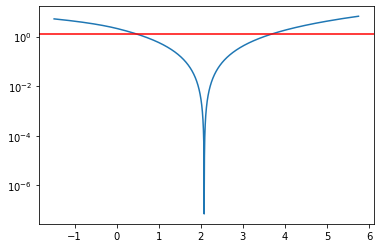

In [50]:
plt.plot(examplearr[:,0],examplearr[:,1], label='Likelihood ratio')
plt.yscale('log')
plt.axhline(y=exampleqcrit, color='r', linestyle='-')


Text(0, 0.5, 'true theta')

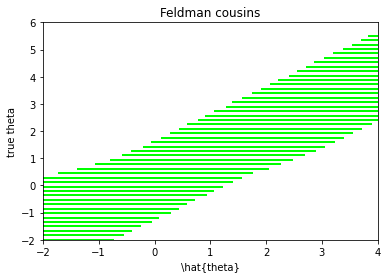

In [44]:
# Plot with range used in the scan

fc_intervals=[]
fc_colors=[]
for i, theta in zip(xIntervals, thetaspace):
    if len(i)==0:
        continue
    #fc_intervals.append([(i[0][0],theta),(i[-1][0],theta)])
    #fc_intervals.append([(min(i),theta),(max(i),theta)])
    fc_intervals.append([(i[0],theta),(i[-1],theta)])
    fc_colors.append([0,1,0,1]) # blue?
from matplotlib import collections  as mc
import pylab as pl
fc_coll = mc.LineCollection(fc_intervals, colors=np.array(fc_colors), linewidths=2)
fig, ax = pl.subplots()
ax.add_collection(fc_coll)
ax.autoscale()
plt.xlim((min(mymeasurements),max(mymeasurements)))
plt.ylim((min(thetaspace), max(thetaspace)))

plt.title('Feldman cousins')
plt.xlabel('\hat{theta}')
plt.ylabel('true theta')


Text(0, 0.5, 'true theta')

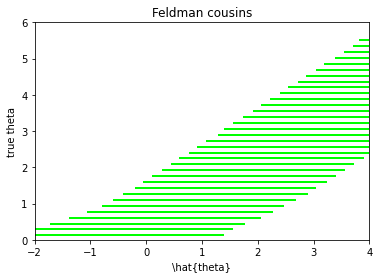

In [49]:
# Plot with the range used by Feldman and Cousins
other_fc_coll = mc.LineCollection(fc_intervals, colors=np.array(fc_colors), linewidths=2)

fig, ax = pl.subplots()
ax.add_collection(other_fc_coll)
#ax.autoscale()
ax.set_xlim((-2.,4.))
ax.set_ylim((0.,6.))

plt.title('Feldman cousins')
plt.xlabel('\hat{theta}')
plt.ylabel('true theta')

We reproduced figure 10 of the Feldman-Cousins paper! If you want, you can draw the envelope of the segments, to see the band as is drawn in the paper.

# Poisson PDF

Now let's work with a poisson PDF, to see the effect of a discrete pdf on the construction.

To show the effect of different ordering principles applied to the Neyman construction of a confidence belt, we want to reproduce the following figures from the F-C paper:

- Figure 5: Neyman construction for upper limits
- Figure 6: Neyman construction for central intervals
- Figure 7: Neymna construction with Feldman-Cousins ("unified") ordering principle

We will be then able to compare the differences

In [52]:
# insert code here...

# Variation of the Gaussian example, where we have the raw data

OK, now that figure 10 is reproduced, let's try to work with the raw measurements, i.e. where each measurement consists in ten i.i.d. normal random variables and where our estimator for the gaussian pdf is the mean of the ten measurements.

Not sure it's useful, it just adds some programming complexity, with no real new statistical insights.
Maybe a more complex likelihood?
Everything that is below this cell, doesn't work yet.

In [ ]:
#First we need a likelihood function, or even better the log-likelihood

# Let's assume we have a sample of N i.i.d. normal random variables with unit variance inserted in a vector x, then the likelihood is:
def lnL(x, theta):
    # Gaussian likelihood
    N=len(x)
    return -N/2.*math.log(2*math.pi)-1/2.*sum((x-[theta for i in range(len(x))])**2)

# Since we are at it, let's also write down the MLE, that in case of a gaussian likelhood we know analytically it is the mean
# We have to slightly modify it, though, to account for the physical boundary (we assume that for a measurement x, the physically-allowed value of the MLE for theta is therefore max(0,x)

def mle(x):
    return max([sum(x)/len(x), 0.])

In [ ]:
# As a test, now let's plot the log likelihood for a specific data realization
#xobs=np.random.normal(loc=10, scale=1.0, size=10)
xobs=np.random.normal(loc=0.5, scale=1.0, size=10)

# Let's scan a parameter range in theta from 5 to 15
thetaspace=np.linspace(5., 15., num=20)
print('theta space shape:', thetaspace.shape, 'dataspace:', xobs.shape)

mylnL=[ lnL(xobs,theta) for theta in thetaspace ]

plt.plot(thetaspace, mylnL, label='lnL function')
plt.axvline(x=mle(xobs), c='red', label='MLE')
plt.title('Log likelihood for the given xobs')
plt.xlabel('theta')
plt.ylabel('lnL(theta; xobs)')
plt.legend(loc='best')

In [ ]:
# Now we need the likelihood ratio.
# Let's first assume we don't have any nuisance parameter.

def q(x, theta):
    return -2*lnL(x, theta) -2*lnL(x,mle(x)) 

# Let's plot the likelihood ratio

myq=[ q(xobs,theta) for theta in thetaspace ]

plt.plot(thetaspace, myq, label='q_xobs(theta)')
plt.axvline(x=mle(xobs), c='red', label='MLE')
plt.title('Likelihood ratio for the given xobs')
plt.xlabel('theta')
plt.ylabel('q(xobs,theta)')
plt.legend(loc='best')

In [ ]:
# Let's generate the distribution of the test statistic for a generic measurement of the mean

def qdist(theta, anal):
    measurements=np.linspace(-5.,15., num=2000)
    return [ q(np.random.normal(loc=mu, scale=1.0, size=10), theta) for mu in measurements] 

# Given this function, we also need a function to compute its integral

def px(qdist,qobs):
    # VERY crude integral
    return(float(sum([ x for x in qdist if x >=qobs]) / sum(qdist)))


In [ ]:
# Choose the critical value
alpha=0.68

xIntervals=[]
mymeasurements=np.linspace(-5.,15., num=50)

for theta in thetaspace:
    xInterval=[]
    for mu in mymeasurements:
        xobsi=np.random.normal(loc=mu, scale=1.0, size=10)
        qobs=q(xobsi,theta)
        qcond=qdist(theta,True)
        if px(qcond,qobs) > alpha:
            xInterval.append(theta)
    xIntervals.append(xInterval)

print(xIntervals)

In [ ]:
# Plot this

lower=[]
upper=[]
for i in xIntervals:
    lower.append(min(i))
    upper.append(max(i))
    
plt.plot(mymeasurements,lower)
plt.plot(mymeasurements,upper)
plt.axvline(x=mle(xobs), c='red', label='MLE')
plt.title('Feldman cousins')
plt.xlabel('\hat{theta}')
plt.ylabel('true theta')
plt.legend(loc='best')